In [1]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

from PIL import Image

import matplotlib.pyplot as plt
import zipfile
from keras.utils import load_img

import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d msambare/fer2013 

zip_ref = zipfile.ZipFile('fer2013.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/fer2013') # Extracts the files into the /fer2013 folder
zip_ref.close()

Saving kaggle.json to kaggle.json
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
train_path = "/fer2013/train/"
test_path = "/fer2013/test/"

print(os.listdir(test_path))
print(os.listdir(train_path))

['sad', 'neutral', 'disgust', 'surprise', 'angry', 'fear', 'happy']
['sad', 'neutral', 'disgust', 'surprise', 'angry', 'fear', 'happy']


In [4]:
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_path, 'train')
test_count = count_exp(test_path, 'test')

print(train_count)
print(test_count)

        sad  neutral  disgust  surprise  angry  fear  happy
train  4830     4965      436      3171   3995  4097   7215
       sad  neutral  disgust  surprise  angry  fear  happy
test  1247     1233      111       831    958  1024   1774


<Axes: >

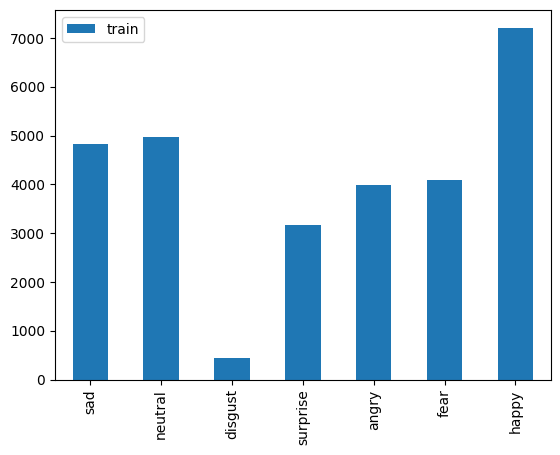

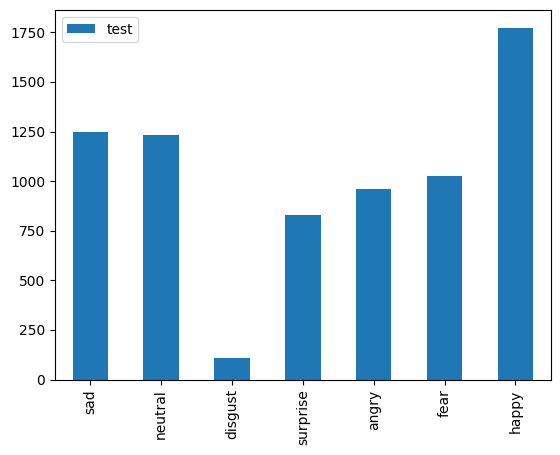

In [5]:
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

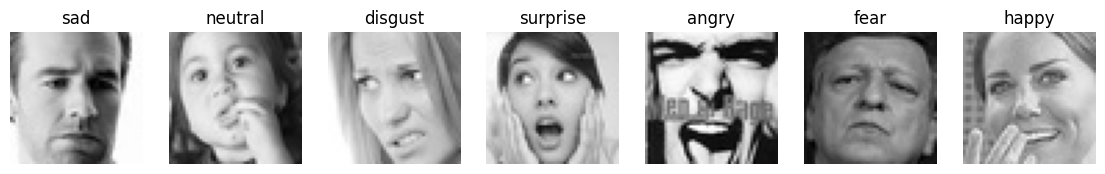

In [6]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_path):
    img = load_img((train_path + expression +'/'+ os.listdir(train_path + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_path,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

training_set.class_indices

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [8]:
def get_model(input_size, classes=7):
    #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = input_size))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Dense layer with 7 neurons (one for each class)
    model.add(Dense(7, activation='softmax'))


    #Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                        

In [10]:
# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)


In [11]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=15,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 2.3589 - accuracy: 0.2606
Epoch 1: val_accuracy improved from -inf to 0.27762, saving model to model_weights.h5
448/448 [==============================] - 954s 2s/step - loss: 2.3589 - accuracy: 0.2606 - val_loss: 2.3046 - val_accuracy: 0.2776
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.9943 - accuracy: 0.3305
Epoch 2: val_accuracy improved from 0.27762 to 0.42020, saving model to model_weights.h5
448/448 [==============================] - 950s 2s/step - loss: 1.9943 - accuracy: 0.3305 - val_loss: 1.6416 - val_accuracy: 0.4202
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.8252 - accuracy: 0.3688
Epoch 3: val_accuracy improved from 0.42020 to 0.44378, saving model to model_weights.h5
448/448 [==============================] - 971s 2s/step - loss: 1.8252 - accuracy: 0.3688 - val_loss: 1.5356 - val_accuracy: 0.4438
Epoch 4/15
448/448 [==============================] 

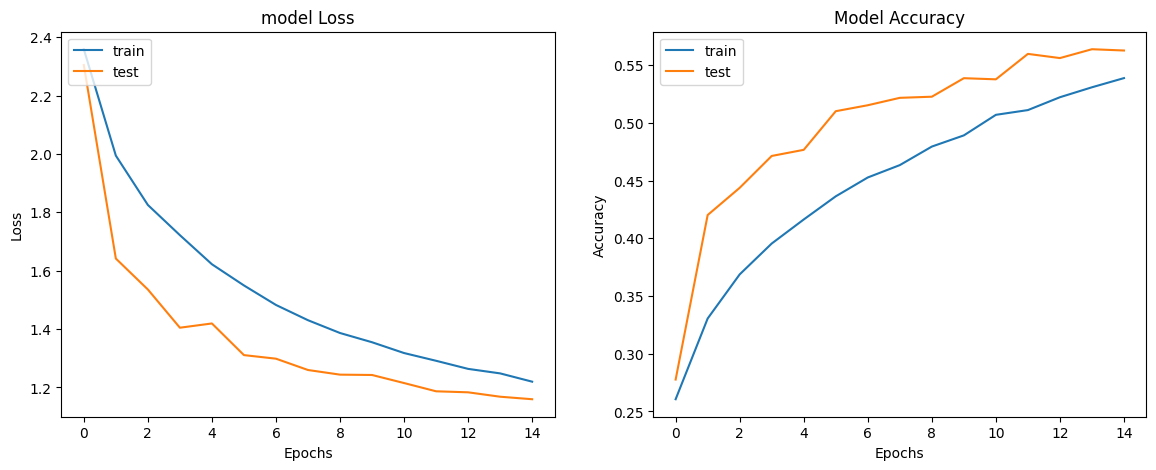

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
train_loss, train_accuracy = fernet.evaluate(training_set)
test_loss, test_accuracy = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

113/113 [==============================] - 54s 475ms/step - loss: 1.1602 - accuracy: 0.5627
final train accuracy = 58.19 , validation accuracy = 56.27


113/113 [==============================] - 54s 477ms/step
Confusion Matrix
[[186   5 111 224 170 150 112]
 [ 19   1   9  30  20  23   9]
 [188   1 107 242 181 178 127]
 [342   7 177 485 310 254 199]
 [239   4 106 304 223 201 156]
 [239   5 139 309 205 209 141]
 [171   4  78 209 139 115 115]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.19      0.16       958
     disgust       0.04      0.01      0.01       111
        fear       0.15      0.10      0.12      1024
       happy       0.27      0.27      0.27      1774
     neutral       0.18      0.18      0.18      1233
         sad       0.18      0.17      0.18      1247
    surprise       0.13      0.14      0.14       831

    accuracy                           0.18      7178
   macro avg       0.16      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178



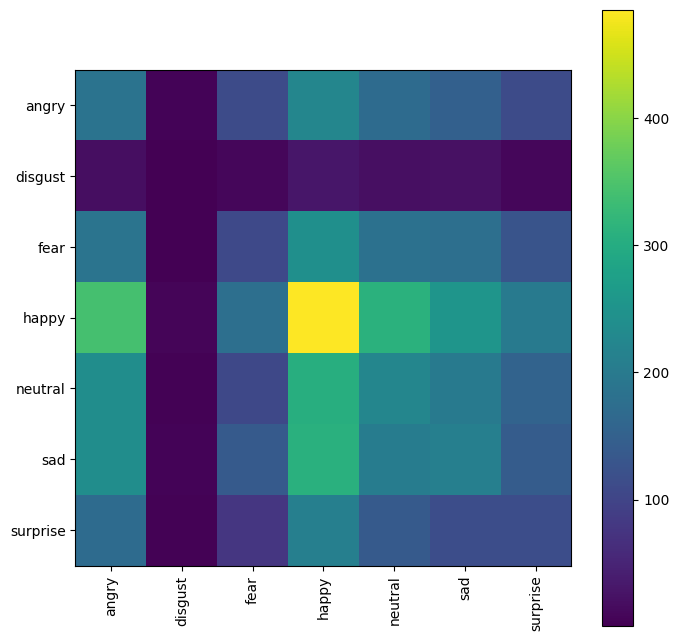

In [15]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

449/449 [==============================] - 238s 527ms/step
Confusion Matrix
[[ 576   16  341 1111  657  847  447]
 [  82    4   44  115   63   84   44]
 [ 610   14  343 1127  700  862  441]
 [1032   31  676 1946 1169 1530  831]
 [ 685   32  438 1352  855 1085  518]
 [ 730   23  396 1329  804 1021  527]
 [ 443   13  272  871  540  676  356]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.03      0.01      0.01       436
        fear       0.14      0.08      0.10      4097
       happy       0.25      0.27      0.26      7215
     neutral       0.18      0.17      0.18      4965
         sad       0.17      0.21      0.19      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.17     28709



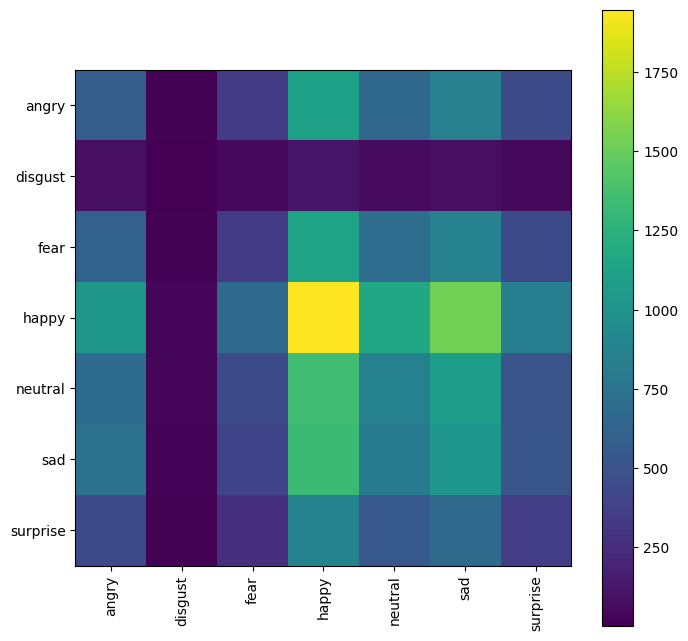

In [16]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)